In [1]:
# import required package
library(caret)
library(dplyr)
library(themis)
library(rpart)
library(ranger)
library(ggplot2)

Loading required package: ggplot2

Loading required package: lattice


Attaching package: ‘caret’


The following object is masked from ‘package:httr’:

    progress



Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: recipes


Attaching package: ‘recipes’


The following object is masked from ‘package:stats’:

    step




# Data Exploration

Let's look at the data. Add sample names as a column in our data so we can merge it with the metadata.

In [41]:
expression_data <- read.table("/kaggle/input/gene-data/GSE69995_re-analyzed_data_matrix.txt", sep = "\t", header = TRUE, stringsAsFactors = FALSE)

# Transpose the data and convert it to a data frame
expression_data <- as.data.frame(t(expression_data))
# Assign the first row as column names and remove the first row from the data
colnames(expression_data) <- expression_data[1, ]
expression_data <- expression_data[-1, ]

expression_data$Sample.name <- rownames(expression_data)
# Reset row names
rownames(expression_data) <- NULL
expression_data <- expression_data[, c(ncol(expression_data), 1:(ncol(expression_data)-1))]
expression_data_numeric <- expression_data
expression_data_numeric[, -which(names(expression_data) == "Sample.name")] <- 
  lapply(expression_data_numeric[, -which(names(expression_data) == "Sample.name")], function(x) {
    as.numeric(x)
  })
expression_data <- expression_data_numeric
head(expression_data)

,Sample.name,AT1G01010,AT1G01030,AT1G01040,AT1G01050,AT1G01060,AT1G01070,AT1G01080,AT1G01090,AT1G01100,⋯,ATMG01220,ATMG01240,ATMG01260,ATMG01290,ATMG01330,ATMG01350,ATMG01360,ATMG01370,ATMG01400,ATMG01410
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,GSM253153,2.94,2.61,8.15,11.58,12.91,8.62,10.80,11.68,13.33,⋯,6.24,3.27,6.08,5.59,0.97,6.42,8.90,8.42,6.39,7.09
2,GSM253154,5.26,6.12,7.90,11.63,13.00,8.77,10.64,11.55,13.09,⋯,5.77,5.07,6.56,6.57,0.81,6.64,8.45,8.74,6.01,6.49
3,GSM253155,2.04,3.70,7.65,11.75,13.51,8.89,10.70,11.57,13.13,⋯,4.92,3.20,4.87,5.31,3.03,6.12,9.16,8.26,6.16,6.32
4,GSM253156,4.47,5.97,8.53,11.98,13.30,8.89,11.35,12.05,13.08,⋯,4.28,4.67,5.55,5.99,2.61,5.91,7.67,8.50,5.75,6.39
5,GSM253157,4.77,5.19,8.38,11.55,13.02,9.52,10.22,11.40,13.16,⋯,4.55,5.87,6.06,5.87,2.58,6.81,8.06,8.65,5.81,6.97
6,GSM253158,3.41,6.25,7.70,11.33,12.37,8.81,9.82,11.65,13.07,⋯,4.73,6.35,6.12,5.88,3.47,6.39,8.30,8.46,6.09,6.82


Now let's look at the metadata

In [42]:
metadata <- read.table("/kaggle/input/gene-data/GSE69995.metadata.tsv", sep = "\t", header = TRUE, stringsAsFactors = FALSE)
head(metadata)

,Sample.name,title,source.name,organism,characteristics..Tissue,characteristics..Developmental.Stage,characteristics..Ecotype,characteristics..Genotype,characteristics..Treatment,characteristics..Original.series.ID,characteristics..Replicate.Group,molecule,label,platform
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,GSM253153,Reanalysis of GSM253153,2h before the end of the night,Arabidopsis thaliana,leaf,6.3,Col-0,wild type,abiotic stress,GSE10016,GSE10016_1,total RNA,biotin,GPL198
2,GSM253154,Reanalysis of GSM253154,end of the night A,Arabidopsis thaliana,leaf,6.3,Col-0,wild type,abiotic stress,GSE10016,GSE10016_2,total RNA,biotin,GPL198
3,GSM253155,Reanalysis of GSM253155,end of the night B,Arabidopsis thaliana,leaf,6.3,Col-0,wild type,abiotic stress,GSE10016,GSE10016_2,total RNA,biotin,GPL198
4,GSM253156,Reanalysis of GSM253156,end of the night C,Arabidopsis thaliana,leaf,6.3,Col-0,wild type,abiotic stress,GSE10016,GSE10016_2,total RNA,biotin,GPL198
5,GSM253157,Reanalysis of GSM253157,2h into an extended night,Arabidopsis thaliana,leaf,6.3,Col-0,wild type,abiotic stress,GSE10016,GSE10016_5,total RNA,biotin,GPL198
6,GSM253158,Reanalysis of GSM253158,4h into an extended nightA,Arabidopsis thaliana,leaf,6.3,Col-0,wild type,abiotic stress,GSE10016,GSE10016_6,total RNA,biotin,GPL198


The column "characteristics..Tissue" contains the required classes. We will extract that column and merge it with the gene expression data.

In [43]:
metadata_selected <- metadata[, c("Sample.name", "characteristics..Tissue")]
merged_data <- merge(expression_data, metadata_selected, by = "Sample.name")

Examine class distribution

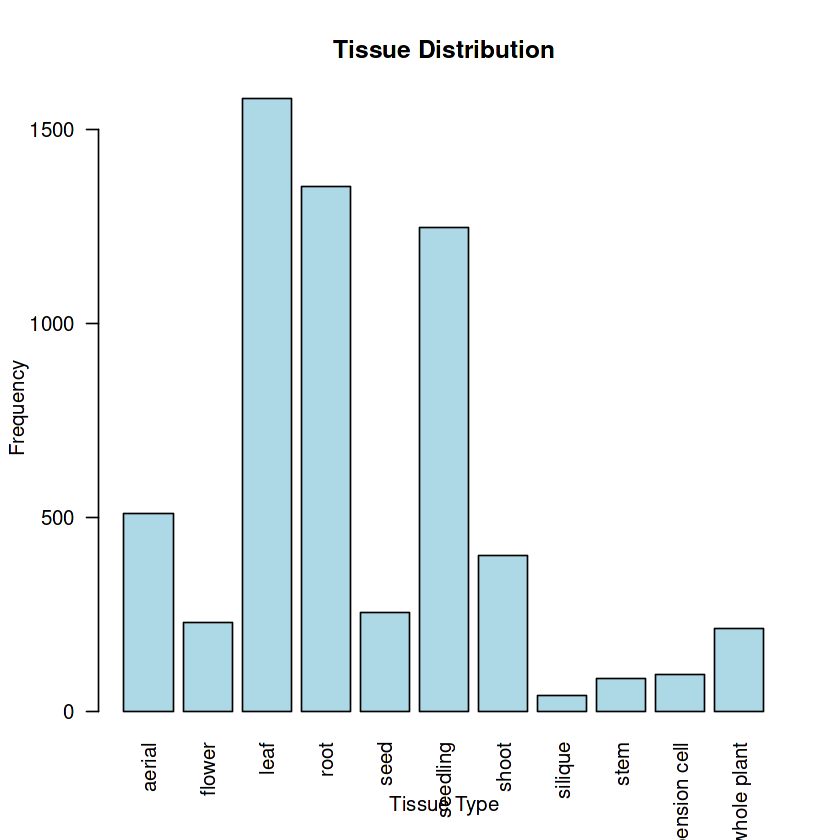

In [44]:
tissue_distribution <- table(merged_data$characteristics..Tissue)
barplot(tissue_distribution, main = "Tissue Distribution", xlab = "Tissue Type", ylab = "Frequency", col = "lightblue", las = 2)

The classes are extremely imbalanced. Having a large class imbalance will cause the model to favour the majority class. To mitigate this, we will perform SMOTE on the underrepresented classes and compare the performances.

# Data Preperation

In [69]:
# Merge the gene expression and label data
original_labels <- unique(merged_data$characteristics..Tissue)
merged_data$characteristics..Tissue <- as.factor(merged_data$characteristics..Tissue)
merged_data <- merged_data[, !names(merged_data) %in% "Sample.name"]
levels(merged_data$characteristics..Tissue)

[1] "aerial"          "flower"          "leaf"            "root"           
 [5] "seed"            "seedling"        "shoot"           "silique"        
 [9] "stem"            "suspension cell" "whole plant"

In [61]:
# Perform an 80-20 train test split
set.seed(24)
trainIndex <- createDataPartition(merged_data$characteristics..Tissue, p = 0.8, list = FALSE)
train_data <- merged_data[trainIndex, ]
test_data <- merged_data[-trainIndex, ]
head(train_data)

,AT1G01010,AT1G01030,AT1G01040,AT1G01050,AT1G01060,AT1G01070,AT1G01080,AT1G01090,AT1G01100,AT1G01110,⋯,ATMG01240,ATMG01260,ATMG01290,ATMG01330,ATMG01350,ATMG01360,ATMG01370,ATMG01400,ATMG01410,characteristics..Tissue
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
1,6.23,6.73,9.31,11.85,6.33,5.86,9.36,12.18,13.96,8.06,⋯,0.74,2.76,5.55,5.23,5.58,8.99,9.93,5.25,5.52,flower
2,6.08,5.91,9.68,11.61,6.27,6.47,9.63,12.47,14.08,8.30,⋯,2.03,2.03,4.36,5.73,5.91,8.65,9.54,5.05,6.06,flower
3,6.82,6.27,9.24,11.57,10.37,6.58,9.40,12.40,13.84,7.77,⋯,4.59,5.17,3.31,5.35,3.93,7.66,9.15,4.64,5.50,flower
4,6.56,6.38,9.31,11.51,10.85,6.99,9.23,12.29,13.95,7.88,⋯,2.84,3.76,4.96,3.66,5.77,7.48,9.60,4.66,5.30,flower
5,6.32,6.03,8.54,11.65,6.82,7.26,9.17,12.25,13.80,8.11,⋯,4.70,4.08,4.14,2.21,5.70,8.58,8.90,2.84,5.50,flower
8,5.89,5.87,9.05,11.55,6.60,6.95,9.25,12.50,13.87,7.77,⋯,5.40,3.92,6.98,3.90,5.87,8.34,9.55,5.49,5.25,flower


In [107]:
# Ssize of the majority class
majority_class_size <- max(table(train_data$`characteristics..Tissue`))

# Apply SMOTE using themis, set over_ratio to match the majority class
smote_train <- smotenc(
  train_data,
  var = "characteristics..Tissue",
  over_ratio = 1  # Balances all classes to match the majority
)

print("Class distribution after applying SMOTE with themis:")
print(table(smote_train$`characteristics..Tissue`))

[1] "Class distribution after applying SMOTE with themis:"

         aerial          flower            leaf            root            seed 
           1264            1264            1264            1264            1264 
       seedling           shoot         silique            stem suspension cell 
           1264            1264            1264            1264            1264 
    whole plant 
           1264 


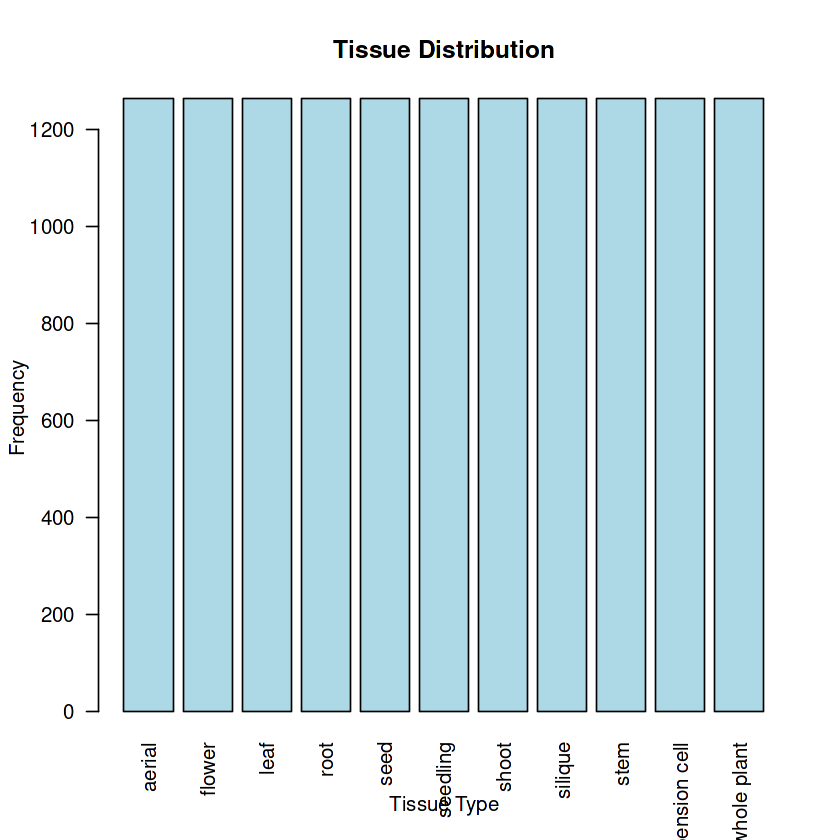

In [110]:
tissue_distribution <- table(smote_train$`characteristics..Tissue`)
barplot(tissue_distribution, main = "Tissue Distribution", xlab = "Tissue Type", ylab = "Frequency", col = "lightblue", las = 2)

In [113]:
# Save train_data to Kaggle's output directory
write.csv(train_data, "/kaggle/working/train_data.csv", row.names = FALSE)

# Save train_smote to Kaggle's output directory
write.csv(smote_train, "/kaggle/working/smote_train.csv", row.names = FALSE)

# Save test_data to Kaggle's output directory
write.csv(test_data, "/kaggle/working/test_data.csv", row.names = FALSE)

# Confirm that files are saved in Kaggle's output directory
print("Files saved as train_data.csv, smote_train.csv, and test_data.csv in /kaggle/working/")

[1] "Files saved as train_data.csv, smote_train.csv, and test_data.csv in /kaggle/working/"


# Feature Selection

Why not PCA? PCA creates fewer dimensions but reduces model explainability.

Instead, we will use a decision tree model to help with feature selection.

In [3]:
train_data <- read.csv("/kaggle/input/processed-data/train_data.csv")
smote_train <- read.csv("/kaggle/input/processed-data/smote_train.csv")
test_data <- read.csv("/kaggle/input/processed-data/test_data.csv")

In [4]:
# Ensure the target variable is a factor for classification
target <- as.factor(train_data$characteristics..Tissue)
features <- train_data[, -which(names(train_data) == "characteristics..Tissue")]

# Train a decision tree using ranger with a max depth of 300
ranger_tree <- ranger(
  dependent.variable.name = "characteristics..Tissue",  # Target variable name
  data = data.frame(characteristics..Tissue = target, features),  # Combined target and features
  num.trees = 1,                    # Single tree
  mtry = ncol(features),            # Use all features at each split
  max.depth = 300,                  # Set maximum depth to 300
  importance = "impurity",          # Use impurity-based feature importance
  classification = TRUE             # Specify classification mode
)

# Extract feature importance scores and select top 500 features
importance_scores <- ranger_tree$variable.importance
top_500_features <- names(sort(importance_scores, decreasing = TRUE)[1:500])

# Subset train, test, and smote_train data to include only the top 500 features
train_data_filtered <- train_data[, c(top_500_features, "characteristics..Tissue")]
test_data_filtered <- test_data[, c(top_500_features, "characteristics..Tissue")]
smote_train_filtered <- smote_train[, c(top_500_features, "characteristics..Tissue")]

# Verify the new dimensions of the data
cat("Filtered train data dimensions:", dim(train_data_filtered), "\n")
cat("Filtered test data dimensions:", dim(test_data_filtered), "\n")
cat("Filtered smote_train data dimensions:", dim(smote_train_filtered), "\n")

Growing trees.. Progress: 100%. Estimated remaining time: 0 seconds.
Filtered train data dimensions: 4816 501 
Filtered test data dimensions: 1199 501 
Filtered smote_train data dimensions: 13904 501 


In [6]:
# Save the files so we don't have to rerun the top chunks
write.csv(train_data_filtered, file = "/kaggle/working/train_data_filtered.csv", row.names = FALSE)
write.csv(test_data_filtered, file = "/kaggle/working/test_data_filtered.csv", row.names = FALSE)
write.csv(smote_train_filtered, file = "/kaggle/working/smote_train_filtered.csv", row.names = FALSE)

# Decision Trees

In [2]:
# Load the saved data
train_data_filtered <- read.csv("/kaggle/input/filtered-data/train_data_filtered.csv")
smote_train_filtered <- read.csv("/kaggle/input/filtered-data/smote_train_filtered.csv")
test_data_filtered <- read.csv("/kaggle/input/filtered-data/test_data_filtered.csv")
train_data_filtered$characteristics..Tissue <- as.factor(train_data_filtered$characteristics..Tissue)
test_data_filtered$characteristics..Tissue <- as.factor(test_data_filtered$characteristics..Tissue)
smote_train_filtered$characteristics..Tissue <- as.factor(smote_train_filtered$characteristics..Tissue)

In [3]:
# Tuning the decision tree models based on max depth
depths <- 1:30
accuracy_results <- data.frame(Depth = depths, Accuracy = numeric(length(depths)))

# Loop over each depth and train a decision tree model
for (i in seq_along(depths)) {
  # Train a decision tree with the specified max depth
  model <- ranger(
    dependent.variable.name = "characteristics..Tissue",
    data = train_data_filtered,
    num.trees = 1,                    # Single tree
    mtry = ncol(train_data_filtered) - 1, # Use all features at each split
    max.depth = depths[i],
    importance = "impurity",
    classification = TRUE
  )
  
  # Predict on the test set
  predictions <- predict(model, data = test_data_filtered[, -which(names(test_data_filtered) == "characteristics..Tissue")])$predictions
  
  # Calculate accuracy
  accuracy <- sum(predictions == test_data_filtered$characteristics..Tissue) / nrow(test_data_filtered)
  
  # Store accuracy for current depth
  accuracy_results$Accuracy[i] <- accuracy
}

# Find the optimal depth with highest accuracy
optimal_depth <- accuracy_results$Depth[which.max(accuracy_results$Accuracy)]
cat("Optimal Depth:", optimal_depth, "\n")

# Train final model using the optimal depth
best_dt_model <- ranger(
  dependent.variable.name = "characteristics..Tissue",
  data = train_data_filtered,
  num.trees = 1,
  mtry = ncol(train_data_filtered) - 1,
  max.depth = optimal_depth,
  importance = "impurity",
  classification = TRUE
)

# Display the optimal model and accuracy results
print(best_dt_model)
print(accuracy_results)

Optimal Depth: 13 
Ranger result

Call:
 ranger(dependent.variable.name = "characteristics..Tissue", data = train_data_filtered,      num.trees = 1, mtry = ncol(train_data_filtered) - 1, max.depth = optimal_depth,      importance = "impurity", classification = TRUE) 

Type:                             Classification 
Number of trees:                  1 
Sample size:                      4816 
Number of independent variables:  500 
Mtry:                             500 
Target node size:                 1 
Variable importance mode:         impurity 
Splitrule:                        gini 
OOB prediction error:             12.06 % 
   Depth  Accuracy
1      1 0.4695580
2      2 0.6538782
3      3 0.6772310
4      4 0.7072560
5      5 0.8065054
6      6 0.8115096
7      7 0.8457048
8      8 0.8557131
9      9 0.8540450
10    10 0.8715596
11    11 0.8807339
12    12 0.8565471
13    13 0.9024187
14    14 0.8798999
15    15 0.8965805
16    16 0.8832360
17    17 0.8865721
18    18 0.8723937
1

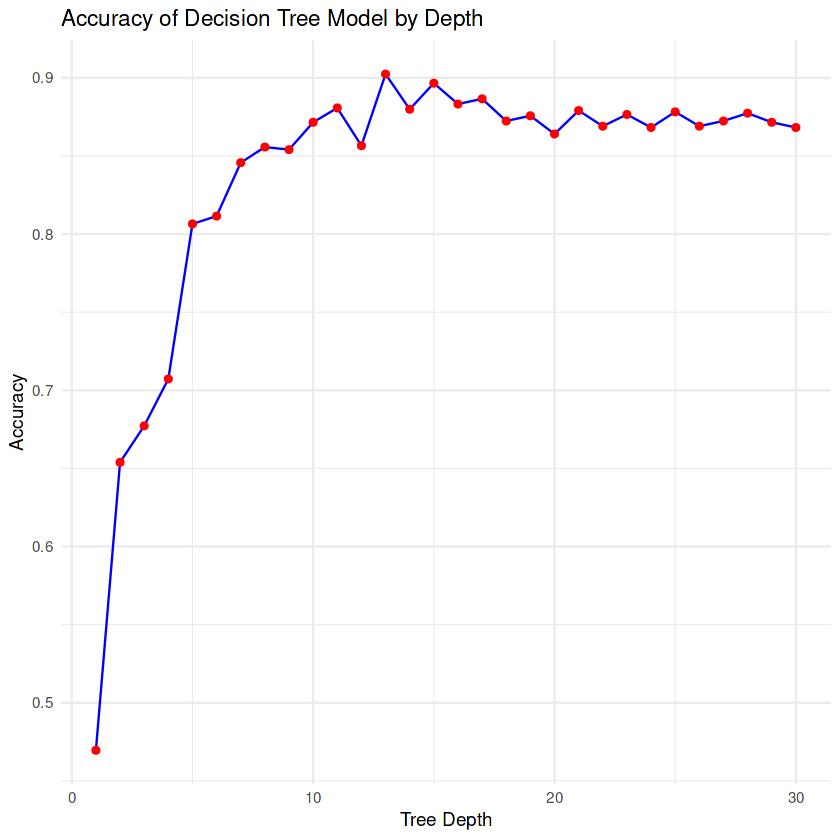

In [4]:
# plot the trend of accuracy with tree depth
ggplot(accuracy_results, aes(x = Depth, y = Accuracy)) +
  geom_line(color = "blue") +
  geom_point(color = "red") +
  labs(title = "Accuracy of Decision Tree Model by Depth",
       x = "Tree Depth",
       y = "Accuracy") +
  theme_minimal()

In [5]:
predictions <- predict(best_dt_model, data = test_data_filtered[, -which(names(test_data_filtered) == "characteristics..Tissue")])$predictions
actuals <- test_data_filtered$characteristics..Tissue

predictions <- as.factor(predictions)
actuals <- as.factor(actuals)
conf_matrix <- confusionMatrix(predictions, actuals)

# Micro precision and recall
micro_precision <- sum(diag(conf_matrix$table)) / sum(conf_matrix$table)
micro_recall <- micro_precision  # Micro recall is the same as micro precision in multiclass

# Macro precision, recall, and f1
macro_precision <- mean(conf_matrix$byClass[, "Precision"], na.rm = TRUE)
macro_recall <- mean(conf_matrix$byClass[, "Recall"], na.rm = TRUE)
macro_f1 <- mean(conf_matrix$byClass[, "F1"], na.rm = TRUE)

# Display the results
cat("Micro Precision:", micro_precision, "\n")
cat("Micro Recall:", micro_recall, "\n")
cat("Macro Precision:", macro_precision, "\n")
cat("Macro Recall:", macro_recall, "\n")
cat("Macro F1 Score:", macro_f1, "\n")
print(conf_matrix)

Micro Precision: 0.8757298 
Micro Recall: 0.8757298 
Macro Precision: 0.8097253 
Macro Recall: 0.8341853 
Macro F1 Score: 0.8181618 
Confusion Matrix and Statistics

                 Reference
Prediction        aerial flower leaf root seed seedling shoot silique stem
  aerial              69      0    6    0    1        5     3       0    0
  flower               0     38    0    0    1        0     2       1    0
  leaf                16      2  297    0    1        9     6       0    0
  root                 0      0    1  262    0        3     0       0    1
  seed                 0      0    0    3   42        2     1       0    0
  seedling             5      0    3    1    3      212     2       1    0
  shoot                7      4    5    1    2       10    59       0    0
  silique              0      0    0    1    1        0     0       6    0
  stem                 0      2    2    1    0        1     3       0   16
  suspension cell      2      0    0    0    0        0  

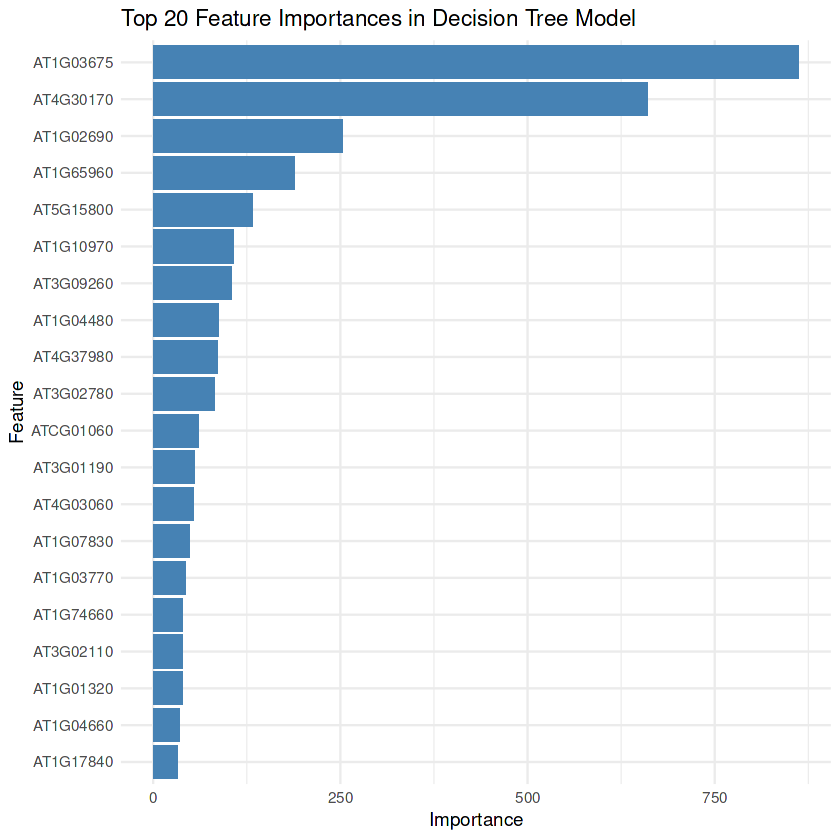

In [6]:
# Extract feature importance from the final decision tree model
importance_scores <- best_dt_model$variable.importance
importance_df <- data.frame(Feature = names(importance_scores), Importance = importance_scores)
top_20_features <- importance_df[order(-importance_df$Importance), ][1:20, ]

# Plot the top 20 feature importances
ggplot(top_20_features, aes(x = reorder(Feature, Importance), y = Importance)) +
  geom_bar(stat = "identity", fill = "steelblue") +
  coord_flip() +
  labs(title = "Top 20 Feature Importances in Decision Tree Model",
       x = "Feature",
       y = "Importance") +
  theme_minimal()

# Decision Tree SMOTE

In [7]:
# Same as above but using SMOTE train data
depths <- 1:30
accuracy_results <- data.frame(Depth = depths, Accuracy = numeric(length(depths)))

for (i in seq_along(depths)) {
  model <- ranger(
    dependent.variable.name = "characteristics..Tissue",
    data = smote_train_filtered,
    num.trees = 1,                    # Single tree
    mtry = ncol(smote_train_filtered) - 1, # Use all features at each split
    max.depth = depths[i],
    importance = "impurity",
    classification = TRUE
  )
  
  predictions <- predict(model, data = test_data_filtered[, -which(names(test_data_filtered) == "characteristics..Tissue")])$predictions
  
  accuracy <- sum(predictions == test_data_filtered$characteristics..Tissue) / nrow(test_data_filtered)
  
  accuracy_results$Accuracy[i] <- accuracy
}

optimal_depth <- accuracy_results$Depth[which.max(accuracy_results$Accuracy)]
cat("Optimal Depth:", optimal_depth, "\n")

best_dt_model <- ranger(
  dependent.variable.name = "characteristics..Tissue",
  data = smote_train_filtered,
  num.trees = 1,
  mtry = ncol(smote_train_filtered) - 1,
  max.depth = optimal_depth,
  importance = "impurity",
  classification = TRUE
)

print(best_dt_model)
print(accuracy_results)

Optimal Depth: 30 
Ranger result

Call:
 ranger(dependent.variable.name = "characteristics..Tissue", data = smote_train_filtered,      num.trees = 1, mtry = ncol(smote_train_filtered) - 1, max.depth = optimal_depth,      importance = "impurity", classification = TRUE) 

Type:                             Classification 
Number of trees:                  1 
Sample size:                      13904 
Number of independent variables:  500 
Mtry:                             500 
Target node size:                 1 
Variable importance mode:         impurity 
Splitrule:                        gini 
OOB prediction error:             4.67 % 
   Depth   Accuracy
1      1 0.02251877
2      2 0.09090909
3      3 0.15596330
4      4 0.31025855
5      5 0.51959967
6      6 0.76063386
7      7 0.79399500
8      8 0.79983319
9      9 0.80233528
10    10 0.83486239
11    11 0.85738115
12    12 0.86155129
13    13 0.86321935
14    14 0.87739783
15    15 0.88073394
16    16 0.85821518
17    17 0.87239366


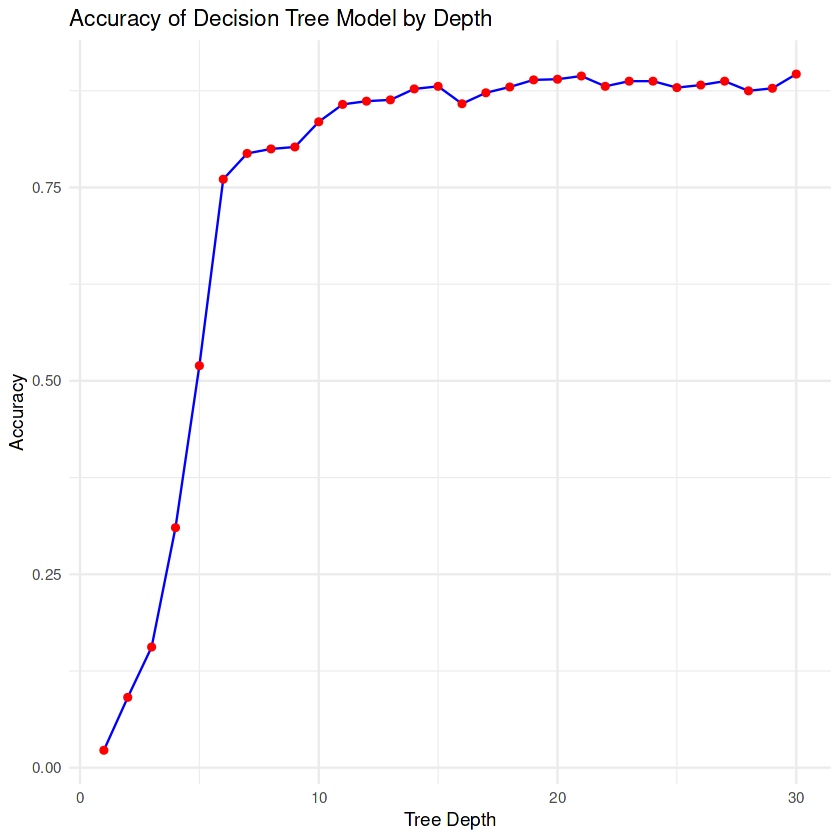

In [8]:
ggplot(accuracy_results, aes(x = Depth, y = Accuracy)) +
  geom_line(color = "blue") +
  geom_point(color = "red") +
  labs(title = "Accuracy of Decision Tree Model by Depth",
       x = "Tree Depth",
       y = "Accuracy") +
  theme_minimal()

In [9]:
predictions <- predict(best_dt_model, data = test_data_filtered[, -which(names(test_data_filtered) == "characteristics..Tissue")])$predictions
actuals <- test_data_filtered$characteristics..Tissue

predictions <- as.factor(predictions)
actuals <- as.factor(actuals)
conf_matrix <- confusionMatrix(predictions, actuals)

# Micro precision and recall
micro_precision <- sum(diag(conf_matrix$table)) / sum(conf_matrix$table)
micro_recall <- micro_precision  # Micro recall is the same as micro precision in multiclass

# Macro precision, recall, and f1
macro_precision <- mean(conf_matrix$byClass[, "Precision"], na.rm = TRUE)
macro_recall <- mean(conf_matrix$byClass[, "Recall"], na.rm = TRUE)
macro_f1 <- mean(conf_matrix$byClass[, "F1"], na.rm = TRUE)

# Display the results
cat("Micro Precision:", micro_precision, "\n")
cat("Micro Recall:", micro_recall, "\n")
cat("Macro Precision:", macro_precision, "\n")
cat("Macro Recall:", macro_recall, "\n")
cat("Macro F1 Score:", macro_f1, "\n")
print(conf_matrix)

Micro Precision: 0.8807339 
Micro Recall: 0.8807339 
Macro Precision: 0.8664735 
Macro Recall: 0.8933736 
Macro F1 Score: 0.8786937 
Confusion Matrix and Statistics

                 Reference
Prediction        aerial flower leaf root seed seedling shoot silique stem
  aerial              78      0    9    1    1       14     8       0    0
  flower               0     45    2    1    0        0     0       0    0
  leaf                 9      0  282    1    2        3    10       0    0
  root                 2      0    7  258    0        3     2       0    1
  seed                 0      0    0    3   47        1     1       0    0
  seedling             6      0    1    5    0      211     0       0    0
  shoot                4      0   12    1    0        5    59       0    0
  silique              0      1    0    0    0        0     0       8    0
  stem                 0      0    0    0    1        0     0       0   16
  suspension cell      0      0    0    0    0        0  

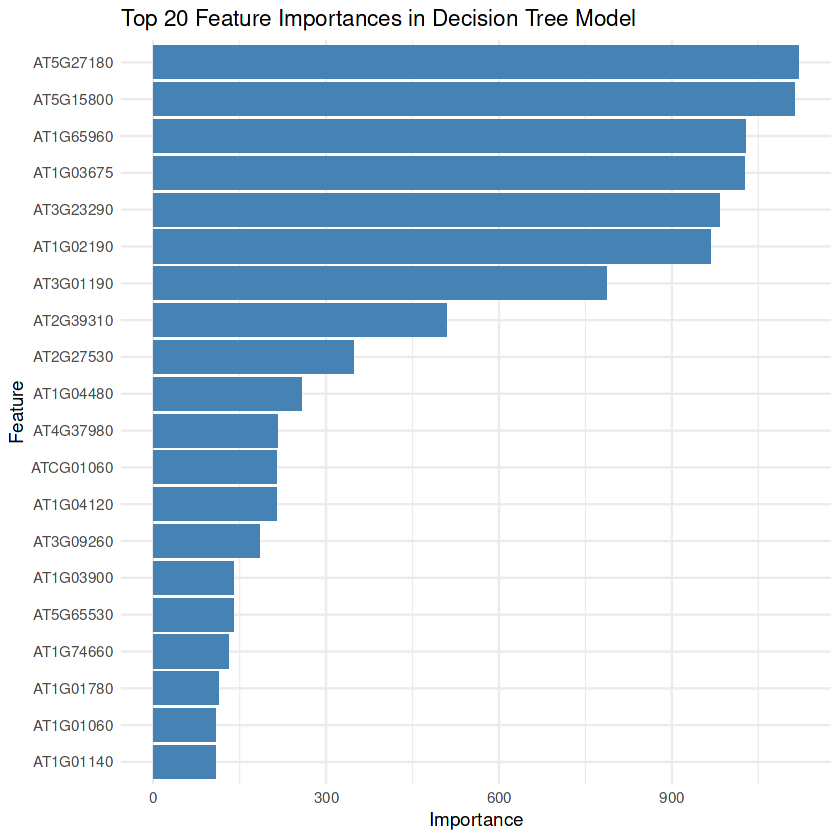

In [10]:
# Extract feature importance from the final decision tree model
importance_scores <- best_dt_model$variable.importance

# Convert to a data frame and select the top 20 features for a clearer plot
importance_df <- data.frame(Feature = names(importance_scores), Importance = importance_scores)
top_20_features <- importance_df[order(-importance_df$Importance), ][1:20, ]

# Plot the top 20 feature importances
ggplot(top_20_features, aes(x = reorder(Feature, Importance), y = Importance)) +
  geom_bar(stat = "identity", fill = "steelblue") +
  coord_flip() +
  labs(title = "Top 20 Feature Importances in Decision Tree Model",
       x = "Feature",
       y = "Importance") +
  theme_minimal()

# Random Forest

In [11]:
# Tune the number of trees created in the random forest model
tree_counts <- seq(10, 300, by = 10)
rf_accuracy_results <- data.frame(Trees = tree_counts, Accuracy = numeric(length(tree_counts)))

# Loop over the range of tree count and train a random forest model for each value
for (i in seq_along(tree_counts)) {
  # Train the random forest each tree having max depth of 15
  rf_model <- ranger(
    dependent.variable.name = "characteristics..Tissue",
    data = train_data_filtered,
    num.trees = tree_counts[i],          
    mtry = sqrt(ncol(train_data_filtered) - 1),
    max.depth = 15, 
    importance = "impurity",
    classification = TRUE
  )
  
  # Predict on the test set
  predictions <- predict(rf_model, data = test_data_filtered[, -which(names(test_data_filtered) == "characteristics..Tissue")])$predictions
  
  # Calculate accuracy
  accuracy <- sum(predictions == test_data_filtered$characteristics..Tissue) / nrow(test_data_filtered)
  
  # Store the accuracy for the current tree count
  rf_accuracy_results$Accuracy[i] <- accuracy
}

In [12]:
# Display the results and find the optimal tree count
print(rf_accuracy_results)
optimal_trees <- rf_accuracy_results$Trees[which.max(rf_accuracy_results$Accuracy)]
cat("Optimal Number of Trees:", optimal_trees, "\n")

# Train the final random forest model with the optimal number of trees
final_rf_model <- ranger(
  dependent.variable.name = "characteristics..Tissue",
  data = train_data_filtered,
  num.trees = optimal_trees,
  mtry = sqrt(ncol(train_data_filtered) - 1),
  max.depth = 15,
  importance = "impurity",
  classification = TRUE
)
# Display the final model and its importance scores
print(final_rf_model)
importance_scores <- final_rf_model$variable.importance

   Trees  Accuracy
1     10 0.9374479
2     20 0.9474562
3     30 0.9507923
4     40 0.9574646
5     50 0.9507923
6     60 0.9516264
7     70 0.9591326
8     80 0.9574646
9     90 0.9541284
10   100 0.9566305
11   110 0.9541284
12   120 0.9507923
13   130 0.9599666
14   140 0.9557965
15   150 0.9524604
16   160 0.9541284
17   170 0.9566305
18   180 0.9524604
19   190 0.9599666
20   200 0.9591326
21   210 0.9549625
22   220 0.9582986
23   230 0.9566305
24   240 0.9557965
25   250 0.9582986
26   260 0.9549625
27   270 0.9516264
28   280 0.9524604
29   290 0.9549625
30   300 0.9566305
Optimal Number of Trees: 130 
Ranger result

Call:
 ranger(dependent.variable.name = "characteristics..Tissue", data = train_data_filtered,      num.trees = optimal_trees, mtry = sqrt(ncol(train_data_filtered) -          1), max.depth = 15, importance = "impurity", classification = TRUE) 

Type:                             Classification 
Number of trees:                  130 
Sample size:                   

In [13]:
rf_predictions <- predict(final_rf_model, data = test_data_filtered[, -which(names(test_data_filtered) == "characteristics..Tissue")])$predictions
actuals <- test_data_filtered$characteristics..Tissue

# Convert predictions and actuals to factors to ensure compatibility
rf_predictions <- as.factor(rf_predictions)
actuals <- as.factor(actuals)

# Confusion matrix for detailed metrics
rf_conf_matrix <- confusionMatrix(rf_predictions, actuals)

# Micro Precision and Recall (aggregated across all classes)
# In multi-class, micro precision and micro recall are the same as overall accuracy
micro_precision_rf <- sum(diag(rf_conf_matrix$table)) / sum(rf_conf_matrix$table)
micro_recall_rf <- micro_precision_rf  # Micro recall is the same as micro precision in multiclass

# Macro Precision, Recall, and F1
macro_precision_rf <- mean(rf_conf_matrix$byClass[, "Precision"], na.rm = TRUE)
macro_recall_rf <- mean(rf_conf_matrix$byClass[, "Recall"], na.rm = TRUE)
macro_f1_rf <- mean(rf_conf_matrix$byClass[, "F1"], na.rm = TRUE)

# Display the results
cat("Random Forest Micro Precision:", micro_precision_rf, "\n")
cat("Random Forest Micro Recall:", micro_recall_rf, "\n")
cat("Random Forest Macro Precision:", macro_precision_rf, "\n")
cat("Random Forest Macro Recall:", macro_recall_rf, "\n")
cat("Random Forest Macro F1 Score:", macro_f1_rf, "\n")
print(rf_conf_matrix)

Random Forest Micro Precision: 0.9549625 
Random Forest Micro Recall: 0.9549625 
Random Forest Macro Precision: 0.9750962 
Random Forest Macro Recall: 0.9309278 
Random Forest Macro F1 Score: 0.9490536 
Confusion Matrix and Statistics

                 Reference
Prediction        aerial flower leaf root seed seedling shoot silique stem
  aerial              92      0    0    0    0        0     1       0    0
  flower               0     44    0    0    0        0     0       0    0
  leaf                 8      2  312    0    0        5    10       0    0
  root                 0      0    1  269    0        1     0       0    0
  seed                 0      0    0    0   51        0     0       0    0
  seedling             0      0    0    1    0      243     5       0    0
  shoot                0      0    2    0    0        0    64       0    0
  silique              0      0    0    0    0        0     0       8    0
  stem                 0      0    0    0    0        0     0 

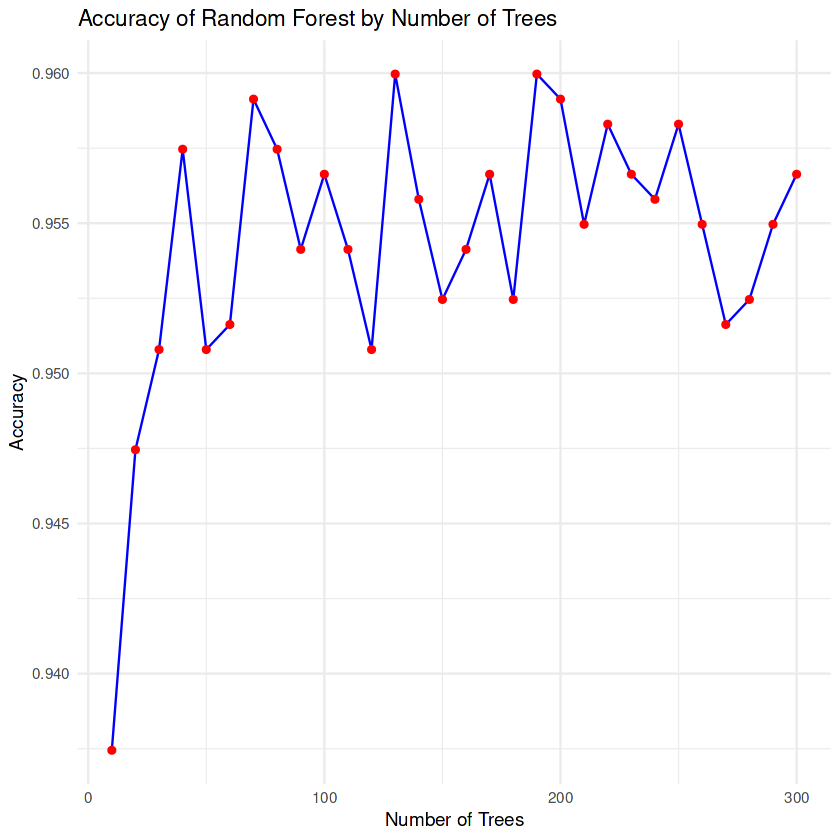

In [14]:
# Plot the accuracy vs. number of trees
ggplot(rf_accuracy_results, aes(x = Trees, y = Accuracy)) +
  geom_line(color = "blue") +
  geom_point(color = "red") +
  labs(title = "Accuracy of Random Forest by Number of Trees",
       x = "Number of Trees",
       y = "Accuracy") +
  theme_minimal()

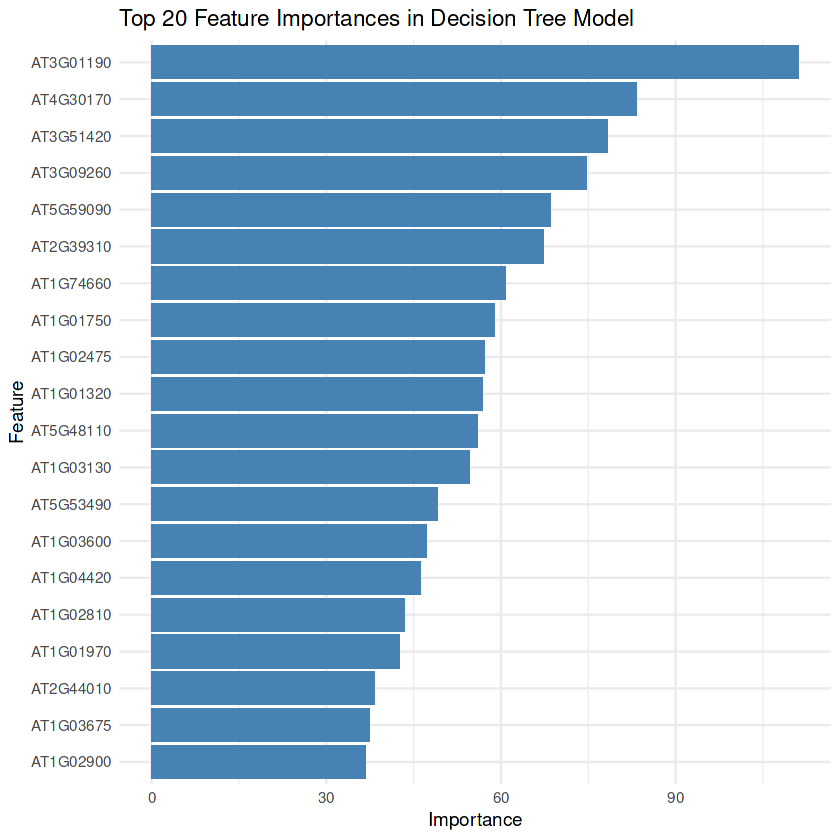

In [15]:
# Extract feature importance from the final decision tree model
importance_scores <- final_rf_model$variable.importance

# Convert to a data frame and select the top 20 features for a clearer plot
importance_df <- data.frame(Feature = names(importance_scores), Importance = importance_scores)
top_20_features <- importance_df[order(-importance_df$Importance), ][1:20, ]

# Plot the top 20 feature importances
ggplot(top_20_features, aes(x = reorder(Feature, Importance), y = Importance)) +
  geom_bar(stat = "identity", fill = "steelblue") +
  coord_flip() +
  labs(title = "Top 20 Feature Importances in Decision Tree Model",
       x = "Feature",
       y = "Importance") +
  theme_minimal()

# Random Forest SMOTE

In [16]:
# Same as above but now using SMOTE train data
tree_counts <- seq(10, 300, by = 10)
rf_accuracy_results <- data.frame(Trees = tree_counts, Accuracy = numeric(length(tree_counts)))

for (i in seq_along(tree_counts)) {
  # Train the random forest with the specified number of trees and max depth of 15
  rf_model <- ranger(
    dependent.variable.name = "characteristics..Tissue",
    data = smote_train_filtered,
    num.trees = tree_counts[i],           # Varying number of trees
    mtry = sqrt(ncol(smote_train_filtered) - 1), # Recommended mtry for random forests
    max.depth = 14,                       # Set max depth to 14
    importance = "impurity",
    classification = TRUE
  )
  
  # Predict on the test set
  predictions <- predict(rf_model, data = test_data_filtered[, -which(names(test_data_filtered) == "characteristics..Tissue")])$predictions
  
  # Calculate accuracy
  accuracy <- sum(predictions == test_data_filtered$characteristics..Tissue) / nrow(test_data_filtered)
  
  # Store the accuracy for the current tree count
  rf_accuracy_results$Accuracy[i] <- accuracy
}

Growing trees.. Progress: 97%. Estimated remaining time: 0 seconds.
Growing trees.. Progress: 95%. Estimated remaining time: 1 seconds.
Growing trees.. Progress: 91%. Estimated remaining time: 3 seconds.
Growing trees.. Progress: 88%. Estimated remaining time: 4 seconds.


In [17]:
# Display the results and find the optimal tree count
print(rf_accuracy_results)
optimal_trees <- rf_accuracy_results$Trees[which.max(rf_accuracy_results$Accuracy)]
cat("Optimal Number of Trees:", optimal_trees, "\n")

# Train the final random forest model with the optimal number of trees
final_rf_model <- ranger(
  dependent.variable.name = "characteristics..Tissue",
  data = smote_train_filtered,
  num.trees = optimal_trees,
  mtry = sqrt(ncol(smote_train_filtered) - 1),
  max.depth = 15,
  importance = "impurity",
  classification = TRUE
)
# Display the final model and its importance scores
print(final_rf_model)
importance_scores <- final_rf_model$variable.importance

   Trees  Accuracy
1     10 0.9616347
2     20 0.9557965
3     30 0.9532944
4     40 0.9641368
5     50 0.9666389
6     60 0.9674729
7     70 0.9624687
8     80 0.9708090
9     90 0.9658048
10   100 0.9691410
11   110 0.9674729
12   120 0.9633028
13   130 0.9658048
14   140 0.9641368
15   150 0.9699750
16   160 0.9691410
17   170 0.9658048
18   180 0.9674729
19   190 0.9649708
20   200 0.9666389
21   210 0.9658048
22   220 0.9733111
23   230 0.9699750
24   240 0.9691410
25   250 0.9649708
26   260 0.9658048
27   270 0.9674729
28   280 0.9716430
29   290 0.9658048
30   300 0.9674729
Optimal Number of Trees: 220 
Ranger result

Call:
 ranger(dependent.variable.name = "characteristics..Tissue", data = smote_train_filtered,      num.trees = optimal_trees, mtry = sqrt(ncol(smote_train_filtered) -          1), max.depth = 15, importance = "impurity", classification = TRUE) 

Type:                             Classification 
Number of trees:                  220 
Sample size:                 

In [18]:
rf_predictions <- predict(final_rf_model, data = test_data_filtered[, -which(names(test_data_filtered) == "characteristics..Tissue")])$predictions
actuals <- test_data_filtered$characteristics..Tissue

# Convert predictions and actuals to factors to ensure compatibility
rf_predictions <- as.factor(rf_predictions)
actuals <- as.factor(actuals)

# Confusion matrix for detailed metrics
rf_conf_matrix <- confusionMatrix(rf_predictions, actuals)

# Micro Precision and Recall (aggregated across all classes)
# In multi-class, micro precision and micro recall are the same as overall accuracy
micro_precision_rf <- sum(diag(rf_conf_matrix$table)) / sum(rf_conf_matrix$table)
micro_recall_rf <- micro_precision_rf  # Micro recall is the same as micro precision in multiclass

# Macro Precision, Recall, and F1
macro_precision_rf <- mean(rf_conf_matrix$byClass[, "Precision"], na.rm = TRUE)
macro_recall_rf <- mean(rf_conf_matrix$byClass[, "Recall"], na.rm = TRUE)
macro_f1_rf <- mean(rf_conf_matrix$byClass[, "F1"], na.rm = TRUE)

# Display the results
cat("Random Forest Micro Precision:", micro_precision_rf, "\n")
cat("Random Forest Micro Recall:", micro_recall_rf, "\n")
cat("Random Forest Macro Precision:", macro_precision_rf, "\n")
cat("Random Forest Macro Recall:", macro_recall_rf, "\n")
cat("Random Forest Macro F1 Score:", macro_f1_rf, "\n")
print(rf_conf_matrix)

Random Forest Micro Precision: 0.9733111 
Random Forest Micro Recall: 0.9733111 
Random Forest Macro Precision: 0.9771204 
Random Forest Macro Recall: 0.9777625 
Random Forest Macro F1 Score: 0.9770637 
Confusion Matrix and Statistics

                 Reference
Prediction        aerial flower leaf root seed seedling shoot silique stem
  aerial              99      0    4    0    0        9     2       0    0
  flower               0     46    0    0    0        0     0       0    0
  leaf                 1      0  308    0    0        5     1       0    0
  root                 0      0    1  270    0        1     0       0    0
  seed                 0      0    0    0   51        0     0       0    0
  seedling             0      0    0    0    0      234     0       0    0
  shoot                0      0    2    0    0        0    77       0    0
  silique              0      0    0    0    0        0     0       8    0
  stem                 0      0    0    0    0        0     0 

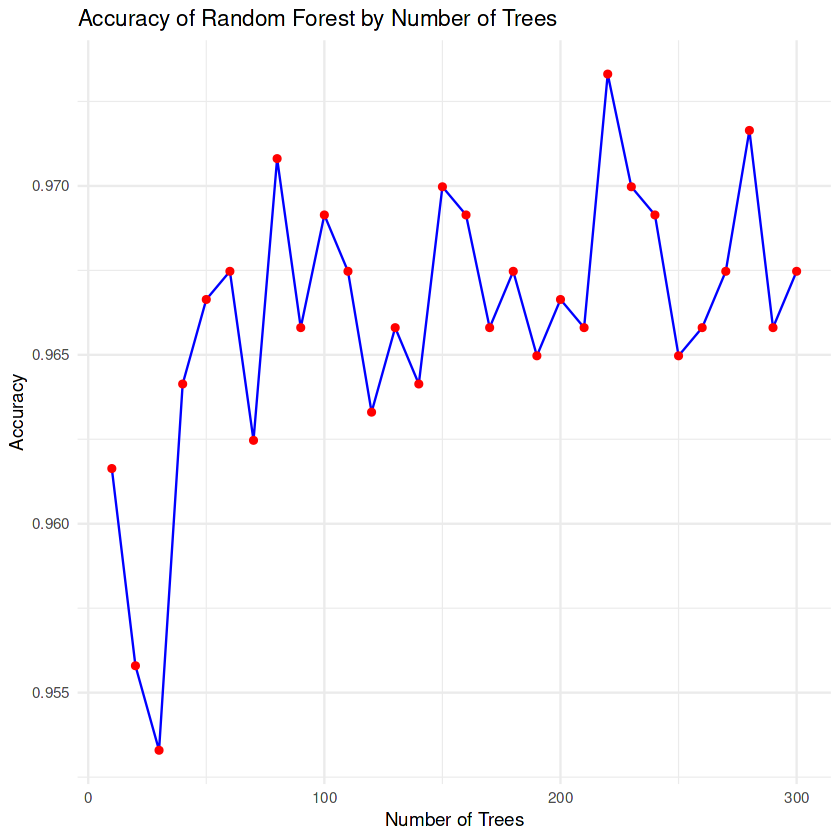

In [19]:
# Plot the accuracy vs. number of trees
ggplot(rf_accuracy_results, aes(x = Trees, y = Accuracy)) +
  geom_line(color = "blue") +
  geom_point(color = "red") +
  labs(title = "Accuracy of Random Forest by Number of Trees",
       x = "Number of Trees",
       y = "Accuracy") +
  theme_minimal()

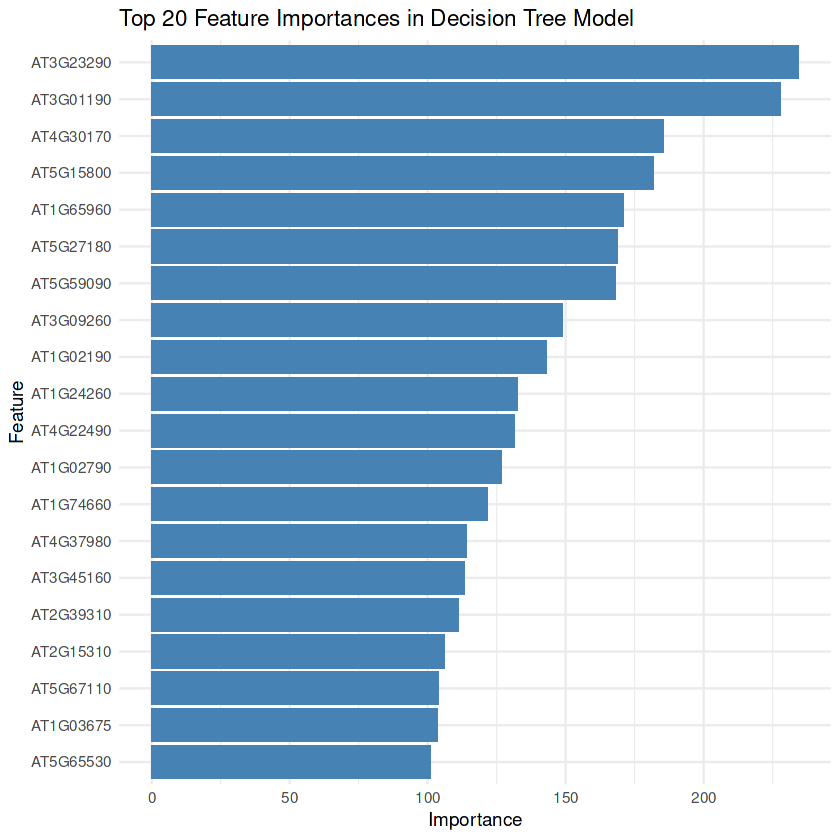

In [20]:
# Extract feature importance from the final decision tree model
importance_scores <- final_rf_model$variable.importance

# Convert to a data frame and select the top 20 features for a clearer plot
importance_df <- data.frame(Feature = names(importance_scores), Importance = importance_scores)
top_20_features <- importance_df[order(-importance_df$Importance), ][1:20, ]

# Plot the top 20 feature importances
ggplot(top_20_features, aes(x = reorder(Feature, Importance), y = Importance)) +
  geom_bar(stat = "identity", fill = "steelblue") +
  coord_flip() +
  labs(title = "Top 20 Feature Importances in Decision Tree Model",
       x = "Feature",
       y = "Importance") +
  theme_minimal()